In [ ]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_126', 'PV_62', 'PV_57']
block_lists = [[7, 8, 9, 10,11,12], [23, 24, 38], [7, 8, 9, 12]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

    for block in block_collection:
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')

    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [ ]:
for block in block_collection:
    block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
    block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
    # then rename in-place
    block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
    block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

try:
    from bokeh_plotter import bokeh_plotter
except ImportError:
    bokeh_plotter = None


def create_saccade_events_combined(
    eye_data_df,
    speed_threshold,
    directional_delta_threshold_deg=25,
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2,
    min_net_disp=0.5,
    bokeh_verify_threshold=False
):
    """
    Combined saccade detection and analysis using pixel-speed-based onset/offset
    with optional directional segmentation and angular metrics.

    Parameters:
      eye_data_df (pd.DataFrame): Must contain at least these columns:
          'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'
      speed_threshold (float): Pixel-speed threshold for saccade detection.
      directional_delta_threshold_deg (float): Threshold for change in instantaneous angular direction (degrees).
      magnitude_calib (float): Calibration factor applied to pixel magnitudes.
      speed_profile (bool): If True, record pixel and angular speed profiles for each segment.
      min_subsaccade_samples (int): Minimum samples for a valid segment.
      min_net_disp (float): Minimal net angular displacement (degrees) to keep a segment.
      bokeh_verify_threshold (bool): If True and bokeh_plotter available, plot speed_r and mark detected onsets.

    Returns:
      df (pd.DataFrame): Original DataFrame copy with added columns:
          'speed_x', 'speed_y', 'speed_r', 'angular_speed_phi', 'angular_speed_theta', 'angular_speed_r'
      saccade_events_df (pd.DataFrame): Rows for each valid subsaccade segment with columns:
          'saccade_start_ind', 'saccade_end_ind', 'saccade_start_timestamp', 'saccade_end_timestamp',
          'saccade_on_ms', 'saccade_off_ms', 'length',
          'magnitude_raw_pixel', 'magnitude_pixel', 'magnitude_raw_angular',
          'overall_angle_pixel', 'overall_angle_angular', 'net_angular_disp',
          'initial_x', 'initial_y', 'end_x', 'end_y', 'calib_dx', 'calib_dy',
          'phi_init_pos', 'phi_end_pos', 'theta_init_pos', 'theta_end_pos',
          'delta_phi', 'delta_theta',
          'speed_profile_pixel', 'speed_profile_pixel_calib', 'speed_profile_angular', 'diameter_profile'
    """
    # Copy to avoid modifying original
    df = eye_data_df.copy()

    # 1. Pixel-speed metrics
    df['speed_x'] = df['center_x'].diff()
    df['speed_y'] = df['center_y'].diff()
    df['speed_r'] = np.hypot(df['speed_x'], df['speed_y'])

    # 2. Angular-speed metrics (requires k_phi, k_theta in degrees)
    df['angular_speed_phi'] = df['k_phi'].diff()
    df['angular_speed_theta'] = df['k_theta'].diff()
    df['angular_speed_r'] = np.hypot(df['angular_speed_phi'], df['angular_speed_theta'])

    # 3. Detect saccade spans based on pixel speed
    df['is_saccade'] = df['speed_r'] > speed_threshold
    on_off = df['is_saccade'].astype(int) - df['is_saccade'].shift(fill_value=0).astype(int)
    saccade_on_inds = np.where(on_off == 1)[0] - 1
    saccade_off_inds = np.where(on_off == -1)[0]

    # Clip indices
    saccade_on_inds = saccade_on_inds[saccade_on_inds >= 0]
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:len(saccade_off_inds)]

    # Optional verification
    if bokeh_verify_threshold and bokeh_plotter is not None:
        bokeh_plotter(data_list=[df['speed_r']], label_list=['Pixel Velocity'], peaks=saccade_on_inds)

    # Helper for minimal angular difference
    def minimal_angle_diff(a, b):
        return ((a - b + 180) % 360) - 180

    saccade_events = []

    # Process each detected saccade span
    for start_i, end_i in zip(saccade_on_inds, saccade_off_inds):
        if end_i <= start_i:
            continue
        span_df = df.iloc[start_i:end_i+1].copy()
        if len(span_df) < min_subsaccade_samples:
            continue

        # Instantaneous angular direction (degrees) as a numpy array
        inst_angles = np.degrees(
            np.arctan2(span_df['angular_speed_theta'], span_df['angular_speed_phi'])
        ).to_numpy()

        # Compute diffs for segmentation on the numpy array
        diffs = np.array([minimal_angle_diff(inst_angles[i+1], inst_angles[i])
                          for i in range(len(inst_angles)-1)])
        boundaries = [0] + list(np.where(np.abs(diffs) > directional_delta_threshold_deg)[0] + 1) + [len(span_df)-1]

        # Segment into subsaccades
        for seg_start, seg_end in zip(boundaries[:-1], boundaries[1:]):
            sub = span_df.iloc[seg_start:seg_end+1]
            if len(sub) < min_subsaccade_samples:
                continue
            # Angular net displacement
            phi0, theta0 = sub['k_phi'].iloc[0], sub['k_theta'].iloc[0]
            phi1, theta1 = sub['k_phi'].iloc[-1], sub['k_theta'].iloc[-1]
            net_disp = np.hypot(phi1-phi0, theta1-theta0)
            if net_disp < min_net_disp:
                continue

            # Pixel-based metrics
            xv0, yv0 = sub['center_x'].iloc[0], sub['center_y'].iloc[0]
            xv1, yv1 = sub['center_x'].iloc[-1], sub['center_y'].iloc[-1]
            pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
            mag_raw_pixel = sub['speed_r'].sum()
            mag_pixel = mag_raw_pixel * magnitude_calib

            # Angular-based metrics
            mag_raw_ang = sub['angular_speed_r'].sum()
            ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)

            # Assemble event
            event = {
                'saccade_start_ind': sub.index[0],
                'saccade_end_ind': sub.index[-1],
                'saccade_start_timestamp': sub['OE_timestamp'].iloc[0],
                'saccade_end_timestamp': sub['OE_timestamp'].iloc[-1],
                'saccade_on_ms': sub['ms_axis'].iloc[0],
                'saccade_off_ms': sub['ms_axis'].iloc[-1],
                'length': sub.index[-1] - sub.index[0],
                'magnitude_raw_pixel': mag_raw_pixel,
                'magnitude_pixel': mag_pixel,
                'magnitude_raw_angular': mag_raw_ang,
                'overall_angle_pixel': pixel_angle,
                'overall_angle_angular': ang_angle,
                'net_angular_disp': net_disp,
                'initial_x': xv0,
                'initial_y': yv0,
                'end_x': xv1,
                'end_y': yv1,
                'calib_dx': (xv1 - xv0) * magnitude_calib,
                'calib_dy': (yv1 - yv0) * magnitude_calib,
                'phi_init_pos': phi0,
                'phi_end_pos': phi1,
                'theta_init_pos': theta0,
                'theta_end_pos': theta1,
                'delta_phi': phi1 - phi0,
                'delta_theta': theta1 - theta0,
                'diameter_profile': sub['pupil_diameter'].values
            }
            if speed_profile:
                event['speed_profile_pixel'] = sub['speed_r'].values
                event['speed_profile_pixel_calib'] = sub['speed_r'].values * magnitude_calib
                event['speed_profile_angular'] = sub['angular_speed_r'].values

            saccade_events.append(event)

    # Build DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)

    # Clean up
    df.drop(columns=['is_saccade'], inplace=True)

    return df, saccade_events_df


In [11]:
# saccade detection and annotation:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_combined(block.left_eye_data,
                                                                             speed_threshold=4,
                                                                             bokeh_verify_threshold=False,
                                                                             magnitude_calib=block.L_pix_size,
                                                                             directional_delta_threshold_deg=180)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_combined(block.right_eye_data,
                                                                              speed_threshold=4,
                                                                              bokeh_verify_threshold=False,
                                                                              magnitude_calib=block.R_pix_size,
                                                                              directional_delta_threshold_deg=180)

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_126, block 011, on PV126_Trial115_eyeTracking_w7


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_126, block 012, on PV126_Trial116_eyeTracking_h8


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_62, block 023, on 2023-04-27_10-52-42


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_62, block 024, on 2023-04-27_11-22-56


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_62, block 038, on 2023-05-01_13-57-45


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)
<ipython-input-10-8cf5101e4ef5>:79: RuntimeWarning: invalid value encountered in double_scalars
  return ((a - b + 180) % 360) - 180
<ipython-input-10-8cf5101e4ef5>:116: RuntimeWarning: invalid value encountered in double_scalars
  pixel_angle = (np.degrees(np.arctan2(yv1-yv0, xv1-xv0)) % 360)
<ipython-input-10-8cf5101e4ef5>:122: RuntimeWarning: invalid value encountered in double_scalars
  ang_angle = (np.degrees(np.arctan2(theta1-theta0, phi1-phi0)) % 360)


In [12]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\Animal=PV_126,recNames=block_007\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\oe_files\PV126_Trial16_wake4_2024-07-18_13-24-41\Record Node 102\analysis\recNames=block_008,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\oe_files\PV126_Trial18_wake5_2024-07-18_14-39-15\Record Node 102\analysis\recNames=block_009,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_010\oe_files\PV126_Trial19_wake6_2024-07-18_15-24-57\Record Node 102\analysis\recNames=block_010,Animal=PV_126\lizM

In [13]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [14]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [15]:
len(saccade_collection)

15952

In [17]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1155it [00:00, 3468.46it/s]
323it [00:00, 7021.77it/s]
326it [00:00, 7090.81it/s]

339 1100
183 385



229it [00:00, 7633.28it/s]
0it [00:00, ?it/s]

190 388
120 260


935it [00:00, 6977.62it/s]
105it [00:00, 7499.65it/s]
577it [00:00, 10122.82it/s]
0it [00:00, ?it/s]

364 972
49 120
130 313


577it [00:00, 7397.43it/s]
1021it [00:00, 8368.90it/s]

199 568



656it [00:00, 5084.14it/s]

584 1044
296 616



621it [00:00, 7759.85it/s]
479it [00:00, 8254.20it/s]
0it [00:00, ?it/s]

207 554
273 502


576it [00:00, 7781.26it/s]


144 456


In [18]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [19]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [24]:
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection,
                                               figure_size=(8, 4),
                                               export_path=None):
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    fig, axs = plt.subplots(1, 2,
                            figsize=figure_size, dpi=150,
                            subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))

    for color, animal in zip(colors, animals):
        df_animal = saccade_collection.query('animal == @animal')

        # --- Right eye ---
        angles_r = df_animal.query('eye == "R"')['overall_angle_angular']
        hist_r, edges_r = np.histogram(angles_r,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        # compute mid‐bin centers as a float64 array
        centers_r = (edges_r[:-1] + edges_r[1:]) / 2.0
        centers_r = np.asarray(centers_r, dtype=float)

        # manual deg→rad
        theta_r = centers_r * (np.pi / 180.0)

        # close the loop
        theta_r = np.concatenate([theta_r, theta_r[:1]])
        hist_r   = np.concatenate([hist_r,   hist_r[:1]])

        axs[0].plot(theta_r, hist_r,
                    label=f"{animal} ({len(angles_r)})",
                    color=color)

        # --- Left eye (same) ---
        angles_l = df_animal.query('eye == "L"')['overall_angle_angular']
        hist_l, edges_l = np.histogram(angles_l,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        centers_l = (edges_l[:-1] + edges_l[1:]) / 2.0
        centers_l = np.asarray(centers_l, dtype=float)
        theta_l   = centers_l * (np.pi / 180.0)

        theta_l = np.concatenate([theta_l, theta_l[:1]])
        hist_l  = np.concatenate([hist_l,  hist_l[:1]])

        axs[1].plot(theta_l, hist_l,
                    label=f"{animal} ({len(angles_l)})",
                    color=color)

    # format
    for ax in axs:
        ax.legend(loc='upper right',
                  bbox_to_anchor=(1.2, 1.1),
                  fontsize=6)
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()

    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = pathlib.Path(export_path) / f"{ts}_MultiAnimal_Saccade_Histogram"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_saccade_angles_histogram.pdf"
        plt.savefig(pdf)
        print("Exported histogram to", pdf)

        pkl = outdir / f"{ts}_saccade_angles_data.pkl"
        with open(pkl, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print("Exported data to", pkl)

    plt.show()


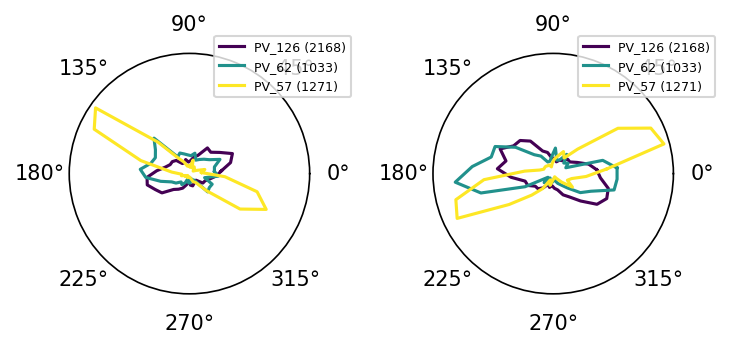

In [25]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [28]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal_xy(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['overall_angle_pixel']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list(np.array((bin_edges_r[:-1] + bin_edges_r[1:]) / 2).astype(int))
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} ({len(saccade_angles_r)} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['overall_angle_pixel']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list(np.array((bin_edges_l[:-1] + bin_edges_l[1:]) / 2).astype(int))
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal} ({len(saccade_angles_l)} saccades)',
            color=color
        )

    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)
        #ax.set_title(f'{title} Saccades', va='bottom')
        ax.grid(False)

        ax.set_yticks([])

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


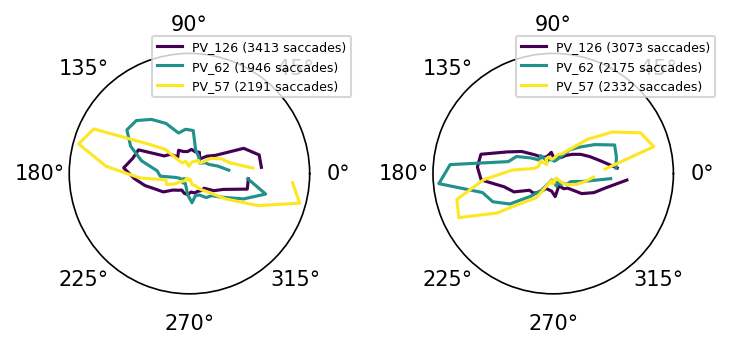

In [29]:
create_saccade_polar_histogram_multianimal_xy(all_saccade_collection, (5,4),export_path=None)